# **MODELO PARA PREDECIR LA PROBABILIDAD DE FALLA DEL DISPOSITIVO UN DÍA ANTES DE LA POSIBLE FALLA**

In [138]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from autots import AutoTS
import pickle
import torch
from neuralforecast import NeuralForecast
from neuralforecast.models import iTransformer
from mlforecast.utils import generate_daily_series
from neuralforecast.losses.pytorch import MSE, MAE

import torch.nn.functional as F
from sklearn.impute import SimpleImputer

In [139]:
from darts.datasets import TimeSeries
from darts.models import CatBoostModel

In [140]:
#conda install llvmlite
#pip install utilsforecast
#pip install missingno
#pip install mlforecast
#conda install -c conda-forge mlforecast

#pip install autots
#pip install darts/pip install darts[all]
#pip install catboost

In [141]:
df_full_devices = pd.read_csv('/home/insightlab/Documents/MercadoLibre/arquivos/full_devices.csv', encoding='latin1')
df_full_devices

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
124489,2015-11-02,Z1F0MA1S,0,18310224,0,0,0,10,353705,8,8,0
124490,2015-11-02,Z1F0Q8RT,0,172556680,96,107,4,11,332792,0,0,13
124491,2015-11-02,Z1F0QK05,0,19029120,4832,0,0,11,350410,0,0,0
124492,2015-11-02,Z1F0QL3N,0,226953408,0,0,0,12,358980,0,0,0


In [142]:
df_full_devices['date'] = pd.to_datetime(df_full_devices['date'])
# Obtener la fecha mínima y máxima
fecha_minima = df_full_devices['date'].min()
fecha_maxima = df_full_devices['date'].max()
print(f'Fecha mínima registrada: {fecha_minima}')
print(f'Fecha máxima registrada: {fecha_maxima}')

Fecha mínima registrada: 2015-01-01 00:00:00
Fecha máxima registrada: 2015-11-02 00:00:00


Tenemos datos desde el 1 de enero de 2015 hasta el 2 de noviembre de 2015.

Al realizar un conteo de días por dispositivo nos muestra que la cantidad de dia son variadas, esto a tomar encuenta al momento d enuestro entrenamiento.

In [143]:
df_full_devices = df_full_devices.rename(columns={'date': 'ds', 'device': 'unique_id', 'failure': 'y'})

In [144]:
# Contar los días únicos por unique_id y ordenarlos en orden creciente
days_per_device = df_full_devices.groupby('unique_id')['ds'].nunique().sort_values(ascending=True)

# Convertir a DataFrame para mostrar
days_per_device = days_per_device.reset_index()
days_per_device.columns = ['unique_id', 'unique_days']
days_per_device

,unique_id,unique_days
0,W1F1DA5ÿ,1
1,W1F0WJFT,3
2,S1F04KSC,4
3,S1F0CTDY,5
4,Z1F1473X,5
...,...,...
1164,S1F0E9EP,304
1165,S1F0GPXY,304
1166,Z1F0QL3N,304
1167,W1F0JXDL,304


In [145]:
df_full_devices[df_full_devices['unique_id'] == 'Z1F0QK05']

,ds,unique_id,y,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
1069,2015-01-01,Z1F0QK05,0,113907728,0,0,0,8,197645,0,0,0
2232,2015-01-02,Z1F0QK05,0,132084392,0,0,0,8,198996,0,0,0
3395,2015-01-03,Z1F0QK05,0,150675000,0,0,0,8,200350,0,0,0
4557,2015-01-04,Z1F0QK05,0,180665192,0,0,0,8,201725,0,0,0
5718,2015-01-05,Z1F0QK05,0,205624528,0,0,0,8,203045,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
124367,2015-10-27,Z1F0QK05,0,194069528,4832,0,0,11,348164,0,0,0
124398,2015-10-29,Z1F0QK05,0,134417624,4832,0,0,11,349066,0,0,0
124429,2015-10-30,Z1F0QK05,0,163139792,4832,0,0,11,349798,0,0,0
124460,2015-10-31,Z1F0QK05,0,30912880,4832,0,0,11,349802,0,0,0


Ya que nuestro menor valor de dias por dispostivo para predecir es de 1, vamos a averiguar en cual disposittivo de valores bajos encontramos la primera  falla, ya que predecir en dispositivos donde todos sus registros es 0 "no falló" no tendria sentido, entonces eliminaremos esos dispositivos bajos que no tuvieron nunca una falla.

In [146]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import shap

In [147]:
import pandas as pd
import numpy as np

# 1) Convert the 'ds' column to three separate float columns: day, month, and year
def convert_ds_to_float(df):
    df['ds'] = pd.to_datetime(df['ds'])  # Convert 'ds' to datetime

    # Extract day, month, and year as separate columns and convert to float
    df['day'] = df['ds'].dt.day.astype(float)
    df['month'] = df['ds'].dt.month.astype(float)
    df['year'] = df['ds'].dt.year.astype(float)

    return df

# 2) Sort the dataset by date
def sort_by_date(df):
    df = df.sort_values(by=['unique_id', 'ds'])
    return df

# 3) Remove multiple rows with the same date and device class (keep one)
def remove_duplicates(df):
    df = df.drop_duplicates(subset=['ds', 'unique_id'], keep='first')
    return df

# 4) Generate concatenation of four consecutive days per device (attributes + day + month) and the class of the fifth day
def generate_sequences(df):
    result = []

    # Group by 'unique_id' to handle each device class separately
    grouped = df.groupby('unique_id')

    # Iterate over each device class group
    for unique_id, group in grouped:
        group = group.sort_values(by='ds').reset_index(drop=True)

        # Generate sequences
        for i in range(len(group) - 4):
            # Concatenate attributes, day, and month of four consecutive rows (excluding 'y' and 'year')
            concat_attributes = pd.concat(
                [group.loc[i:i+3, [f'attribute{j}' for j in range(1, 10)] + ['day', 'month']].reset_index(drop=True)], axis=1
            ).values.flatten()

            fifth_day_class = group.loc[i+4, 'y']  # Fifth day's class
            result.append(list(concat_attributes) + [fifth_day_class, unique_id])  # Append concatenated attributes, day, month, and the class

    return result

# Complete function to process the dataset
def process_dataset(df):
    df = convert_ds_to_float(df)
    df = sort_by_date(df)
    df = remove_duplicates(df)
    sequences = generate_sequences(df)
    
    # Create column names dynamically: 4 days * (9 attributes + 2 date parts) = 44 columns, plus 'y' and 'unique_id'
    columns = [f'attr{idx}' for idx in range(1, 45)] + ['y', 'unique_id']  # 44 columns for attributes and date parts + class y + device id
    sequences_df = pd.DataFrame(sequences, columns=columns)
    
    return sequences_df

# Assuming 'df' is your dataset
sequences_df = process_dataset(df_full_devices)

# Display the resulting DataFrame
print(sequences_df.head())  # Display the first few rows of the result


         attr1  attr2  attr3  attr4  attr5     attr6  attr7  attr8  attr9  \
0  215630672.0   56.0    0.0   52.0    6.0  407438.0    0.0    0.0    7.0   
1    1650864.0   56.0    0.0   52.0    6.0  407438.0    0.0    0.0    7.0   
2   14533968.0    0.0    0.0    0.0    5.0  688952.0    0.0    0.0    0.0   
3   46202296.0    0.0    0.0    0.0    5.0  688952.0    0.0    0.0    0.0   
4   61370680.0    0.0    3.0    0.0    6.0  403174.0    0.0    0.0    0.0   

   attr10  attr11       attr12  attr13  attr14  attr15  attr16    attr17  \
0     1.0     1.0    1650864.0    56.0     0.0    52.0     6.0  407438.0   
1     2.0     1.0  124017368.0    56.0     0.0    52.0     6.0  407438.0   
2     6.0     5.0   46202296.0     0.0     0.0     0.0     5.0  688952.0   
3     7.0     5.0  214383720.0     0.0     0.0     0.0     5.0  688964.0   
4     1.0     1.0  191946112.0     0.0     3.0     0.0     6.0  403174.0   

   attr18  attr19  attr20  attr21  attr22       attr23  attr24  attr25  \
0     

In [148]:
pd.set_option('display.max_columns', None)
sequences_df.head()

,attr1,attr2,attr3,attr4,attr5,attr6,attr7,attr8,attr9,attr10,attr11,attr12,attr13,attr14,attr15,attr16,attr17,attr18,attr19,attr20,attr21,attr22,attr23,attr24,attr25,attr26,attr27,attr28,attr29,attr30,attr31,attr32,attr33,attr34,attr35,attr36,attr37,attr38,attr39,attr40,attr41,attr42,attr43,attr44,y,unique_id
0,215630672.0,56.0,0.0,52.0,6.0,407438.0,0.0,0.0,7.0,1.0,1.0,1650864.0,56.0,0.0,52.0,6.0,407438.0,0.0,0.0,7.0,2.0,1.0,124017368.0,56.0,0.0,52.0,6.0,407438.0,0.0,0.0,7.0,3.0,1.0,128073224.0,56.0,0.0,52.0,6.0,407439.0,0.0,0.0,7.0,4.0,1.0,0,S1F01085
1,1650864.0,56.0,0.0,52.0,6.0,407438.0,0.0,0.0,7.0,2.0,1.0,124017368.0,56.0,0.0,52.0,6.0,407438.0,0.0,0.0,7.0,3.0,1.0,128073224.0,56.0,0.0,52.0,6.0,407439.0,0.0,0.0,7.0,4.0,1.0,97393448.0,56.0,0.0,52.0,6.0,408114.0,0.0,0.0,7.0,5.0,1.0,0,S1F01085
2,14533968.0,0.0,0.0,0.0,5.0,688952.0,0.0,0.0,0.0,6.0,5.0,46202296.0,0.0,0.0,0.0,5.0,688952.0,0.0,0.0,0.0,7.0,5.0,214383720.0,0.0,0.0,0.0,5.0,688964.0,0.0,0.0,0.0,8.0,5.0,243346080.0,0.0,0.0,0.0,5.0,689035.0,0.0,0.0,0.0,9.0,5.0,0,S1F013BB
3,46202296.0,0.0,0.0,0.0,5.0,688952.0,0.0,0.0,0.0,7.0,5.0,214383720.0,0.0,0.0,0.0,5.0,688964.0,0.0,0.0,0.0,8.0,5.0,243346080.0,0.0,0.0,0.0,5.0,689035.0,0.0,0.0,0.0,9.0,5.0,85127128.0,0.0,0.0,0.0,5.0,689062.0,0.0,0.0,0.0,10.0,5.0,0,S1F013BB
4,61370680.0,0.0,3.0,0.0,6.0,403174.0,0.0,0.0,0.0,1.0,1.0,191946112.0,0.0,3.0,0.0,6.0,403174.0,0.0,0.0,0.0,2.0,1.0,77681360.0,0.0,3.0,0.0,6.0,403174.0,0.0,0.0,0.0,3.0,1.0,82195688.0,0.0,3.0,0.0,6.0,403175.0,0.0,0.0,0.0,4.0,1.0,0,S1F0166B


In [149]:
X = sequences_df.drop(columns=['y']).values 
y = sequences_df['y'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [195]:
# Define the ODU method to be used at each iteration
def ODU(model, x_tr, y_tr):
    y_pred = model.predict_proba(x_tr)
    n_minor = list(y_tr).count(1)  # Count of the minor class

    major_indexes = []
    minor_indexes = []
    major_class_pred = []

    # Separate major and minor class samples
    for idx, prediction in enumerate(y_pred):
        if y_tr[idx] == 1:
            minor_indexes.append(idx)
        else:
            major_class_pred.append(prediction[0])  # Probability of being the major class
            major_indexes.append(idx)

    # Sort major class samples by their predicted probability
    major_indexes = [x for _, x in sorted(zip(major_class_pred, major_indexes))]

    # Select an equal number of major and minor samples
    selected_indexes = major_indexes[:300*n_minor] + minor_indexes

    new_x_tr = [x_tr[i] for i in selected_indexes]
    new_y_tr = [y_tr[i] for i in selected_indexes]

    return new_x_tr, new_y_tr

# Initialize CatBoost parameters
catboost_params = {
    'iterations': 100,  # Each run with limited iterations to simulate incremental learning
    'learning_rate': 0.01,
    'depth': 10,
    'eval_metric': 'Logloss',
    'random_seed': 42,
    'verbose': False
}

cat_features = [sequences_df.drop(columns=['y']).columns.get_loc('unique_id')]  # Obtener el índice de la columna 'unique_id'

# Step 2: Train the initial CatBoost model
model = CatBoostClassifier(**catboost_params)
model.fit(X_train, y_train, cat_features=cat_features)

# Step 3: Apply the ODU logic iteratively
n_iterations = 100  # Define the number of iterations (pseudo-epochs)
for iteration in range(n_iterations):
    # Apply ODU to get a balanced training set
    X_train_balanced, y_train_balanced = ODU(model, X_train, y_train)

    # Convert to numpy arrays for CatBoost
    X_train_balanced = np.array(X_train_balanced)
    y_train_balanced = np.array(y_train_balanced)

    # Train a new CatBoost model on the balanced data
    model.fit(X_train_balanced, y_train_balanced, cat_features=cat_features)

    print(f"Iteration {iteration + 1} complete. Model updated.")

# Step 4: After the iterations, evaluate the final model on the test set
y_pred = model.predict(X_test)
print("First few predictions:", y_pred[:5])

Iteration 1 complete. Model updated.
Iteration 2 complete. Model updated.
Iteration 3 complete. Model updated.
Iteration 4 complete. Model updated.
Iteration 5 complete. Model updated.
Iteration 6 complete. Model updated.
Iteration 7 complete. Model updated.
Iteration 8 complete. Model updated.
Iteration 9 complete. Model updated.
Iteration 10 complete. Model updated.
Iteration 11 complete. Model updated.
Iteration 12 complete. Model updated.
Iteration 13 complete. Model updated.
Iteration 14 complete. Model updated.
Iteration 15 complete. Model updated.
Iteration 16 complete. Model updated.
Iteration 17 complete. Model updated.
Iteration 18 complete. Model updated.
Iteration 19 complete. Model updated.
Iteration 20 complete. Model updated.
Iteration 21 complete. Model updated.
Iteration 22 complete. Model updated.
Iteration 23 complete. Model updated.
Iteration 24 complete. Model updated.
Iteration 25 complete. Model updated.
Iteration 26 complete. Model updated.
Iteration 27 complete

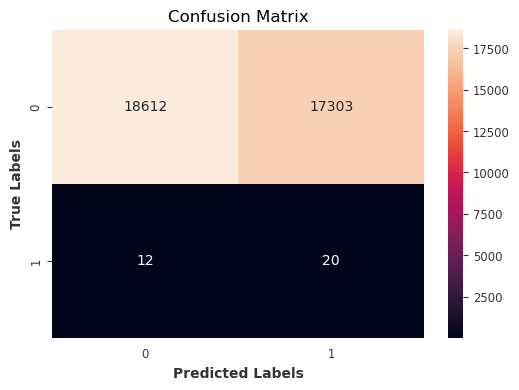

In [196]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix as a heatmap using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [197]:
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average='weighted'))

0.518318635769327
0.6819152370823364


Se exploró el dataset en el notebook anterior, y se intentó trabajar con series temporales como ser iTransformers e Darts Catboosts, pero uno de los problemas es que iTransformers es muy limitado a datos categoricos y manejar lags dinamicos ya que el historico de cantidad de dias segun dispostivo varia bastante entre 1 a 300 dias. Asi mismo, trabajar con CatBoost fue problematico ya que ningun dispositivo superaba a tener mas de 1 error dentro de su historico, y entrenar un modelo que no tiene variabilidad en lo que desea aprender, se vuelve limitante. 

Por ello se exploró mejor trabajar con las fechas de forma separada, convirtiendolo en valores numericos juntando los dias y meses, se ordenó el conjunto de datos por fecha; es decir, si hay varias filas con la misma fecha y la misma clase 'device', se eliminaron las filas duplicadas, dejando solo una de ellas; Para cada clase de 'device', se generó una lista resultante de la concatenación de los atributos de fechas de cuatro días consecutivos para ese dispositivo (si hay una brecha entre estos días, se mantuvo la concatenación). Se generó el mayor número posible de listas, es decir, aunque las listas contengan una secuencia consecutiva de fechas/días, algunas listas pueden contener el mismo día, por ejemplo, lista1 = [día1, día2, día3, día4] y lista2 = [día2, día3, día4, día5]. Se entrenó un modelo CatBoost para predecir el valor de la salida y del día posterior al último día de una lista determinada. Este enfoque permite manejar variables categóricas ('device') que contienen un gran número de clases, sin ignorar la temporalidad de los datos.

La problamtica que nos topamos en los otros métodos explorados de que el conjunto de datos está altamente desbalanceado, de modo que el número de clases y=1 es mucho menor que el número de clases y=0. Abordamos el método ODU (one side under sampling) propuesto en un articulo, que consiste en, dadas N iteraciones del método, hacer lo siguiente:

*   Entrenar el modelo durante un cierto número de iteraciones
*   Usar el modelo entrenado para predecir las probabilidades de las clases en el conjunto de datos
*   Seleccionar todas las muestras n_min de la clase minoritaria y las n_min muestras de la clase mayoritaria que el modelo tuvo más dificultad en predecir (con menor probabilidad para la clase)
*   Las muestras seleccionadas se utilizan para entrenar el modelo en la siguiente iteración.


Hicimos una pequeña modificación en el algoritmo y usamos una cantidad de muestras de la clase mayoritaria menor que la de la clase minoritaria (debido a la gran disparidad).



In [31]:
# Agrupar por 'unique_id' y filtrar los dispositivos que tienen más de un fallo
devices_with_more_than_one_fail = df_full_devices[df_full_devices['y'] == 1].groupby('unique_id').filter(lambda x: len(x) > 0)

# Verificar que el último registro de cada dispositivo no sea una falla
filtered_devices = []
for device in devices_with_more_than_one_fail['unique_id'].unique():
    device_data = df_full_devices[df_full_devices['unique_id'] == device].sort_values(by='ds', ascending=True)
    
    # Verificar que la última fila del dispositivo no tenga y == 1
    if device_data.iloc[-1]['y'] != 1:
        filtered_devices.append(device)

# Mostrar los dispositivos que cumplen la condición
print("Dispositivos con más de 1 falla pero sin fallo en la última línea:")
filtered_devices

Dispositivos con más de 1 falla pero sin fallo en la última línea:


['S1F136J0', 'W1F0KCP2', 'W1F0M35B', 'S1F0GPFZ', 'W1F11ZG9']

In [28]:
df_temp = df_full_devices
# Agrupar por 'unique_id' y contar los casos donde y == 1
devices_with_fails_more_than_2 = df_temp[df_temp['y'] == 1].groupby('unique_id').filter(lambda x: len(x) > 0)

# Obtener los unique_id que cumplen la condición
filtered_devices = devices_with_fails_more_than_2['unique_id'].unique()

filtered_devices

array(['S1F0RRB1', 'S1F0CTDN', 'W1F0PNA5', 'W1F13SRV', 'W1F1230J',
       'W1F0T034', 'S1F0GG8X', 'S1F023H2', 'S1F0QY11', 'S1F0S2WJ',
       'W1F0Z1W9', 'W1F15S4D', 'Z1F0LVPW', 'Z1F0NVZA', 'Z1F1FCH5',
       'S1F0P3G2', 'W1F0F6BN', 'W1F0P114', 'W1F0X4FC', 'S1F0LCTV',
       'W1F03DP4', 'W1F0FW0S', 'S1F10E6M', 'S1F11MB0', 'W1F0SGHR',
       'W1F0VDH2', 'W1F0TA59', 'Z1F0LVGY', 'Z1F0MCCA', 'Z1F0P5D9',
       'W1F0NZZZ', 'W1F0T074', 'S1F0DSTY', 'S1F0TQCV', 'Z1F04GCH',
       'W1F08EDA', 'W1F1C9TE', 'S1F0S4CA', 'W1F19BPT', 'Z1F130LH',
       'S1F0GJW3', 'S1F0LD2C', 'W1F0Q8FH', 'Z1F0FSBY', 'W1F0Z4EA',
       'Z1F0QH0C', 'S1F0S4T6', 'W1F1CDDP', 'S1F0S57T', 'S1F0JD7P',
       'S1F13H80', 'Z1F148T1', 'S1F0RSZP', 'S1F0GKFX', 'S1F0LCVC',
       'W1F1BZTM', 'Z1F1RJFA', 'S1F13589', 'S1F136J0', 'S1F0F4EB',
       'W1F1C9WG', 'S1F0RR35', 'Z1F1653X', 'Z1F1AG5N', 'W1F0KCP2',
       'W1F0M35B', 'Z1F1901P', 'S1F0GKL6', 'Z1F0K451', 'W1F03D4L',
       'W1F0FKWW', 'S1F0PJJW', 'W1F0X5GW', 'S1F0L0DW', 'W1F0WB

# **Modelo CatBoost**

In [10]:
print(df_full_devices['y'].dtype)
print(df_full_devices['y'].unique())

int64
[0 1]


In [11]:
df_full_devices['attribute9'].isna().sum()

0

In [12]:
# Filtrar los datos para el dispositivo 'Z1F0QK05'
device_data = df_full_devices[df_full_devices['unique_id'] == 'S1F0QY11'].copy()

# Convertir la columna 'ds' a formato datetime
device_data['ds'] = pd.to_datetime(device_data['ds'])

In [13]:
device_data['y'].unique()

array([0, 1])

In [14]:
device_data[device_data['y'] == 1]['y'].count()

1

In [15]:
# Crear un rango de fechas completo desde la fecha mínima hasta la fecha máxima
start_date = device_data['ds'].min()
end_date = device_data['ds'].max()
print(f'Fecha mínima registrada: {start_date}')
print(f'Fecha máxima registrada: {end_date}')

Fecha mínima registrada: 2015-01-01 00:00:00
Fecha máxima registrada: 2015-01-19 00:00:00


In [16]:
device_data

,ds,unique_id,y,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
183,2015-01-01,S1F0QY11,0,10684704,0,0,9,7,207615,16,16,0
1346,2015-01-02,S1F0QY11,0,32796680,0,0,9,7,208967,16,16,0
2509,2015-01-03,S1F0QY11,0,56076040,0,0,9,7,210275,16,16,0
3672,2015-01-04,S1F0QY11,0,78015216,0,0,9,7,211571,16,16,0
4833,2015-01-05,S1F0QY11,0,108615480,0,0,9,7,212896,16,16,0
5958,2015-01-06,S1F0QY11,0,128138264,0,0,9,7,214214,16,16,0
6957,2015-01-07,S1F0QY11,0,148330672,0,0,9,7,215530,16,16,0
7753,2015-01-08,S1F0QY11,0,174379792,0,0,9,7,216827,16,16,0
8509,2015-01-09,S1F0QY11,0,195103112,0,0,9,7,218159,16,16,0
9265,2015-01-10,S1F0QY11,0,213001552,0,0,9,7,219476,16,16,0


In [17]:
complete_date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Comparar las fechas del rango completo con las fechas del DataFrame
missing_dates = complete_date_range.difference(device_data['ds'])

# Mostrar los días faltantes (si existen)
if len(missing_dates) > 0:
    print(f"Fechas faltantes para el dispositivo: {missing_dates}")
else:
    print("No faltan fechas en el dispositivo.")

No faltan fechas en el dispositivo.


In [18]:
# Reindexar el DataFrame para incluir las fechas faltantes
device_data = device_data.set_index('ds').reindex(complete_date_range).reset_index().rename(columns={'index': 'ds'})

In [19]:
# Rellenar las covariables y el target con el valor del día anterior (forward fill)
device_data = device_data.fillna(method='ffill')

/tmp/ipykernel_13461/2219980398.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  device_data = device_data.fillna(method='ffill')


In [20]:
unique_days = device_data['ds'].nunique() - 1 

In [21]:
unique_days

18

In [22]:
# Asegurarse de que las fechas están ordenadas
device_data = device_data.sort_values(by='ds').reset_index(drop=True)

# Eliminar duplicados en las fechas
device_data = device_data.drop_duplicates(subset='ds', keep='first')

In [23]:
# Establecer la frecuencia común ('D' para diaria) y reindexar
device_data.set_index('ds', inplace=True)
device_data = device_data.asfreq('D')

In [24]:
# Imputar covariables faltantes con la media (antes de eliminar filas del target)
covariables = ['attribute1', 'attribute2', 'attribute3', 'attribute4', 
               'attribute5', 'attribute6', 'attribute7', 'attribute8', 'attribute9']

# Restaurar la columna 'ds' como índice temporal
device_data.reset_index(inplace=True)

In [26]:
device_data

,ds,unique_id,y,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F0QY11,0,10684704,0,0,9,7,207615,16,16,0
1,2015-01-02,S1F0QY11,0,32796680,0,0,9,7,208967,16,16,0
2,2015-01-03,S1F0QY11,0,56076040,0,0,9,7,210275,16,16,0
3,2015-01-04,S1F0QY11,0,78015216,0,0,9,7,211571,16,16,0
4,2015-01-05,S1F0QY11,0,108615480,0,0,9,7,212896,16,16,0
5,2015-01-06,S1F0QY11,0,128138264,0,0,9,7,214214,16,16,0
6,2015-01-07,S1F0QY11,0,148330672,0,0,9,7,215530,16,16,0
7,2015-01-08,S1F0QY11,0,174379792,0,0,9,7,216827,16,16,0
8,2015-01-09,S1F0QY11,0,195103112,0,0,9,7,218159,16,16,0
9,2015-01-10,S1F0QY11,0,213001552,0,0,9,7,219476,16,16,0


In [26]:
# Definir la serie temporal del target (falla)
target_series = TimeSeries.from_dataframe(
    device_data.iloc[:-1], time_col='ds', value_cols='y', fill_missing_dates=False, freq='D'
)

# Crear covariables pasadas
past_cov_series = TimeSeries.from_dataframe(
    device_data.iloc[:-1], time_col='ds', value_cols=covariables, fill_missing_dates=False, freq='D'
)

# Definir el último día para hacer la predicción
future_cov_series = TimeSeries.from_dataframe(
    device_data, time_col='ds', value_cols=covariables, fill_missing_dates=True, freq='D'
)

# Definir el modelo con el tamaño dinámico para cada dispositivo según los días únicos
model = CatBoostModel(
    lags=min(unique_days, 20),  # Ajustar lags dinámicamente
    lags_past_covariates=min(unique_days, 20),
    lags_future_covariates=[0]
)

In [173]:
future_cov_series

<TimeSeries (DataArray) (ds: 181, component: 9, sample: 1)>
array([[[1.67368080e+07],
        [0.00000000e+00],
        [0.00000000e+00],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[4.11529440e+07],
        [0.00000000e+00],
        [0.00000000e+00],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[6.36466560e+07],
        [0.00000000e+00],
        [0.00000000e+00],
        ...,
...
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[2.40927120e+07],
        [0.00000000e+00],
        [0.00000000e+00],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[1.78051496e+08],
        [0.00000000e+00],
        [0.00000000e+00],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]]])
Coordinates:
  * ds         (ds) datetime64[ns] 2015-01-01 2015-01-02 ... 2015-06-30
  * component  (component) object 'attribute1' 'attribute2' ... 'attribute9'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [174]:
# Verificar que las fechas del target y covariables pasadas estén alineadas
if not target_series.time_index.equals(past_cov_series.time_index):
    print(f"Error: Fechas no alineadas en target y covariables pasadas para el dispositivo.")

In [175]:
# Verificar que la covariable futura sea al menos el último día para la predicción
if len(future_cov_series) != 1:
    print(f"Error: Las covariables futuras no contienen solo el último día para el dispositivo.")


Error: Las covariables futuras no contienen solo el último día para el dispositivo.


In [176]:
# Entrenar el modelo en este dispositivo específico
model.fit(target_series, past_covariates=past_cov_series, future_covariates=future_cov_series)

CatBoostError: /src/catboost/catboost/libs/metrics/metric.cpp:6748: All train targets are equal

In [ ]:
# Predecir el siguiente día (último día disponible)
pred = model.predict(1, past_covariates=past_cov_series, future_covariates=future_cov_series)

# Mostrar la predicción
print("Predicción para el dispositivo 'Z1F0QK05':")
print(pred.pd_dataframe())

In [ ]:
# Lista para guardar las predicciones
all_forecasts = []

# Iterar sobre cada dispositivo
for uid in df_full_devices['unique_id'].unique():
    device_data = df_full_devices[df_full_devices['unique_id'] == uid].copy()

    # Asegurarse de que las fechas están ordenadas
    device_data = device_data.sort_values(by='ds').reset_index(drop=True)

    # Contar los días únicos para este dispositivo
    unique_days = device_data['ds'].nunique() - 1  # Restar 1 para dejar un día para predicción

    # Si no hay suficientes días únicos para hacer una predicción, saltar este dispositivo
    if unique_days < 100:
        continue

    device_data['ds'] = pd.to_datetime(device_data['ds'])

    # Eliminar duplicados en las fechas
    device_data = device_data.drop_duplicates(subset='ds', keep='first')

    # Establecer la frecuencia común ('D' para diaria) y reindexar
    device_data.set_index('ds', inplace=True)
    device_data = device_data.asfreq('D')

    # Imputar covariables faltantes con la media (antes de eliminar filas del target)
    covariables = ['attribute1', 'attribute2', 'attribute3', 'attribute4', 
                   'attribute5', 'attribute6', 'attribute7', 'attribute8', 'attribute9']
    imputer = SimpleImputer(strategy='mean')
    device_data[covariables] = imputer.fit_transform(device_data[covariables])

    # Restaurar la columna 'ds' como índice temporal
    device_data.reset_index(inplace=True)

    # Eliminar filas con valores faltantes en el target
    device_data = device_data.dropna(subset=['y'])


    # Obtener el rango de fechas para asegurar que todas las series compartan las mismas fechas
    date_range = pd.date_range(start=device_data['ds'].min(), end=device_data['ds'].max(), freq='D')

    # Reindexar para alinear las series
    device_data = device_data.set_index('ds').reindex(date_range).reset_index().rename(columns={'index': 'ds'})

    # Definir la serie temporal del target (falla)
    target_series = TimeSeries.from_dataframe(
        device_data.iloc[:-1], time_col='ds', value_cols='y', fill_missing_dates=True, freq='D'
    )

    # Crear covariables pasadas
    past_cov_series = TimeSeries.from_dataframe(
        device_data.iloc[:-1], time_col='ds', value_cols=covariables, fill_missing_dates=True, freq='D'
    )

    # Definir el último día para hacer la predicción
    future_cov_series = TimeSeries.from_dataframe(
        device_data.iloc[-1:], time_col='ds', value_cols=covariables, fill_missing_dates=True, freq='D'
    )

    # Verificar que las fechas del target y covariables pasadas estén alineadas
    if not target_series.time_index.equals(past_cov_series.time_index):
        print(f"Error: Fechas no alineadas en target y covariables pasadas para el dispositivo {uid}.")
        continue

    # Verificar que la covariable futura sea al menos el último día para la predicción
    if len(future_cov_series) != 1:
        #print(f"Error: Las covariables futuras no contienen solo el último día para el dispositivo {uid}.")
        continue

    # Definir el modelo con el tamaño dinámico para cada dispositivo según los días únicos
    model = CatBoostModel(
        lags=min(unique_days, 20),  # Ajustar lags dinámicamente
        lags_past_covariates=min(unique_days, 20),
        lags_future_covariates=[0]
    )

    # Entrenar el modelo en este dispositivo específico
    try:
        model.fit(target_series, past_covariates=past_cov_series, future_covariates=future_cov_series)
    except ValueError as e:
        print(f"Error entrenando el dispositivo {uid}: {e}")
        continue

    # Predecir el siguiente día
    try:
        pred = model.predict(1, past_covariates=past_cov_series, future_covariates=future_cov_series)
    except ValueError as e:
        print(f"Error prediciendo para el dispositivo {uid}: {e}")
        continue

    # Guardar la predicción junto con el dispositivo
    pred_df = pred.pd_dataframe()
    pred_df['unique_id'] = uid
    all_forecasts.append(pred_df)


In [ ]:
# Combinar todas las predicciones
final_forecasts = pd.concat(all_forecasts).reset_index(drop=True)
final_forecasts

# Configuración del modelo iTransformer
Vamos a usar el modelo iTransformer ya que está diseñado para capturar dependencias a largo plazo en los datos de manera más efectiva pues maneja de manera eficiente múltiples series temporales simultáneamente como en nuestro caso tenemos múltiples dispositivos (cada uno con su propia serie temporal).

In [25]:
len(df_full_devices['unique_id'].unique())

1080

Solo que algo que nos restringe que para definir un iTransformer se debe definir el input_size los dias d emanera estatica, y nuestros cantidades variadas como vimos desde 5 dias, y que ya tiene fallas. Vamos a entrenar dos modelos para pdoer comparar que tan bueno es para responder a nuestra problematica.

In [26]:
model = iTransformer(
    h=1,  # Horizonte de predicción: 1 día antes de la falla
    input_size=4,  # Usamos los últimos días como entrada
    n_series=df_full_devices['unique_id'].nunique(),  # Número de series (dispositivos)
    #n_series=1,
    hidden_size=128,
    n_heads=2,
    e_layers=2,
    d_layers=1,
    d_ff=4,
    factor=1,
    dropout=0.1,
    use_norm=True,
    loss=MSE(),
    #valid_loss=MAE(),
    valid_loss=MSE(),
    early_stop_patience_steps=0,  # Desactivar early stopping
    batch_size=4
)

Seed set to 1


In [66]:
# Lista para guardar todas las predicciones
all_forecasts = []

# Preparar los datos para el entrenamiento
train_data_list = []
test_data_list = []

# Iterar sobre cada dispositivo
for uid in df_full_devices['unique_id'].unique():
    # Filtrar los datos por dispositivo
    device_data = df_full_devices[df_full_devices['unique_id'] == uid].copy()
    
    # Asegurarse de que las fechas están ordenadas
    device_data = device_data.sort_values(by='ds').reset_index(drop=True)

    # Tomar todos los días menos uno como entrenamiento y el último día como prueba
    train_data = device_data.iloc[:-1].reset_index(drop=True)
    test_data = device_data.iloc[-1:].reset_index(drop=True)
    
    # Agregar los datos a la lista
    train_data_list.append(train_data)
    test_data_list.append(test_data)

# Combinar todas las series temporales en un solo DataFrame para entrenamiento y prueba
train_data_combined = pd.concat(train_data_list).reset_index(drop=True)
test_data_combined = pd.concat(test_data_list).reset_index(drop=True)

# Entrenar el modelo único para todas las series temporales
fcst = NeuralForecast(models=[model], freq='D')
fcst.fit(df=train_data_combined, val_size=0)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MSE                    | 0      | train
1 | valid_loss    | MSE                    | 0      | train
2 | padder        | ConstantPad1d          | 0      | train
3 | scaler        | TemporalNorm           | 0      | train
4 | enc_embedding | DataEmbedding_inverted | 640    | train
5 | encoder       | TransEncoder           | 135 K  | train
6 | projector     | Linear                 | 129    | train
-----------------------------------------------------------------
136 K     Trainable params
0         Non-trainable params
136 K     Total params
0.546     Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.


In [67]:
# Guardar el modelo entrenado
torch.save(model.state_dict(), 'iTransformer_model.pth')

Para el manejo de las series temporales multivariadas el modelo va esperar que para cada dispositivo se provea una secuencia completa de datos (todas las fechas correspondientes) para poder hacer predicciones correctamente. Por ello, si un valor para esa fecha no existe, usaremos "Iterative Imputer" que es una técnicapara cada valor faltante en una columna, entrena un modelo de regresión utilizando las otras columnas como características. Esto se hace de forma iterativa hasta que todas las columnas con valores faltantes han sido imputadas.

In [71]:
# Crear un rango de fechas para cada dispositivo en el conjunto de prueba
all_ids = test_data_combined['unique_id'].unique()
all_dates = pd.date_range(start=test_data_combined['ds'].min(), end=test_data_combined['ds'].max())

# Crear un DataFrame con todas las combinaciones posibles de unique_id y fechas
complete_index = pd.MultiIndex.from_product([all_ids, all_dates], names=['unique_id', 'ds'])
complete_df = pd.DataFrame(index=complete_index).reset_index()

# Fusionar con el conjunto de prueba para asegurarse de que todas las combinaciones existan
test_data_combined_full = pd.merge(complete_df, test_data_combined, on=['unique_id', 'ds'], how='left')

In [29]:
# Fusionar con el conjunto de prueba para asegurarse de que todas las combinaciones existan
test_data_combined_full = pd.merge(complete_df, test_data_combined, on=['unique_id', 'ds'], how='left')
# Seleccionar las columnas de características a imputar
features = ['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 
            'attribute6', 'attribute7', 'attribute8', 'attribute9']

# Imputar características faltantes con ffill (rellenar hacia adelante) o interpolar
test_data_combined_full[features] = test_data_combined_full.groupby('unique_id')[features].ffill().bfill()

# Asegurarse de que no hay NaNs en las características
test_data_combined_full[features] = test_data_combined_full[features].fillna(0)

In [32]:
# Asegurarte de que el DataFrame no contenga la columna 'y' o 'failure'
test_data_combined_full = test_data_combined_full.drop(columns=['y'], errors='ignore')

In [50]:
# Realizar la predicción para el último día de cada dispositivo
forecasts = fcst.predict(futr_df=test_data_combined_full)

/home/insightlab/anaconda3/envs/darts/lib/python3.10/site-packages/neuralforecast/core.py:865: UserWarning: Dropped 325,080 unused rows from `futr_df`.
  warnings.warn(f"Dropped {dropped_rows:,} unused rows from `futr_df`.")
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/home/insightlab/anaconda3/envs/darts/lib/python3.10/site-packages/neuralforecast/core.py:209: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [51]:
# Extraer la probabilidad de falla predicha aplicando la función sigmoide
#forecasts['predicted_probability'] = forecasts[model.__class__.__name__]
# Aplicar la función sigmoide para convertir las salidas a probabilidades
forecasts['predicted_probability'] = torch.sigmoid(torch.tensor(forecasts['iTransformer'])).numpy()

/tmp/ipykernel_1764887/479724305.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasts['predicted_probability'] = torch.sigmoid(torch.tensor(forecasts['iTransformer'])).numpy()


In [52]:
forecasts

,ds,iTransformer,predicted_probability
unique_id,,,
S1F01085,2015-01-06,-0.000234,0.499942
S1F013BB,2015-05-11,-0.000234,0.499942
S1F0166B,2015-01-06,-0.000234,0.499942
S1F01E6Y,2015-02-17,-0.000234,0.499942
S1F01JE0,2015-01-06,-0.000234,0.499942
...,...,...,...
Z1F1VMZB,2015-10-19,-0.000234,0.499942
Z1F1VQFY,2015-06-30,-0.000234,0.499942
Z1F26YZB,2015-03-25,-0.000234,0.499942


In [53]:
# Clasificar como 1 si la probabilidad es mayor a 0.5
forecasts['predicted_failure'] = forecasts['predicted_probability'].apply(lambda x: 1 if x > 0.5 else 0)

# Añadir la columna con el valor real (falla o no falla)
forecasts['real_failure'] = test_data_combined['y'].values

forecasts = forecasts.reset_index()

final_results = forecasts[['unique_id', 'ds', 'real_failure', 'predicted_probability', 'predicted_failure']]

In [59]:
results_transformers = final_results.query('real_failure == 1')

In [60]:
results_transformers

,unique_id,ds,real_failure,predicted_probability,predicted_failure
7,S1F01XDJ,2015-04-16,1,0.499942,0
22,S1F03499,2015-05-11,1,0.499942,0
39,S1F06R6W,2015-01-06,1,0.499942,0
55,S1F0BWZ3,2015-10-19,1,0.499942,0
58,S1F0CSBR,2015-01-05,1,0.499942,0
...,...,...,...,...,...
1038,Z1F17XPD,2015-05-11,1,0.499942,0
1054,Z1F1A83K,2015-05-11,1,0.499942,0
1062,Z1F1AGW1,2015-01-05,1,0.499942,0
1069,Z1F1HEQR,2015-01-06,1,0.499942,0


/tmp/ipykernel_1764887/3664299486.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_transformers['comparison'] = results_transformers.apply(


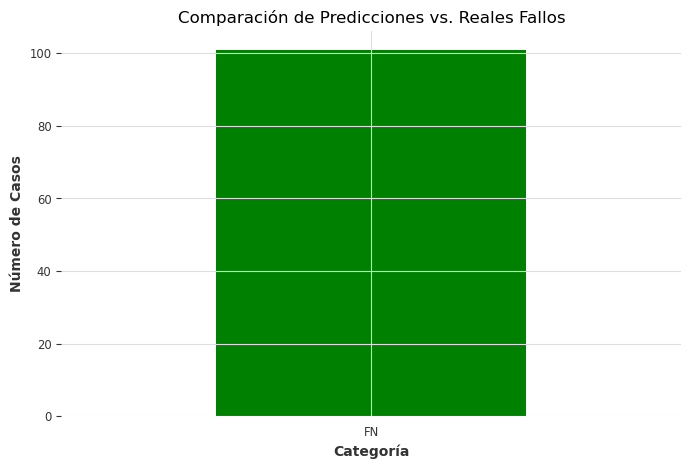

In [65]:
# Crear una nueva columna que combine el valor real y el valor predicho
results_transformers['comparison'] = results_transformers.apply(
    lambda row: 'TP' if row['real_failure'] == 1 and row['predicted_failure'] == 1 else
                'FP' if row['real_failure'] == 0 and row['predicted_failure'] == 1 else
                'TN' if row['real_failure'] == 0 and row['predicted_failure'] == 0 else
                'FN', axis=1)

# Contar cuántas veces aparece cada categoría (TP, FP, TN, FN)
comparison_counts = results_transformers['comparison'].value_counts()

# Graficar los resultados
plt.figure(figsize=(8, 5))
comparison_counts.plot(kind='bar', color=['green', 'red', 'blue', 'orange'])
plt.title('Comparación de Predicciones vs. Reales Fallos')
plt.xlabel('Categoría')
plt.ylabel('Número de Casos')
plt.xticks(rotation=0)
plt.grid(True)

# Mostrar el gráfico
plt.show()

In [9]:
# Generar todas las combinaciones posibles de unique_id y ds
all_ids = Y_test_df['unique_id'].unique()
all_dates = pd.date_range(start=Y_test_df['ds'].min(), end=Y_test_df['ds'].max())

# Crear un DataFrame de todas las combinaciones posibles
complete_index = pd.MultiIndex.from_product([all_ids, all_dates], names=['unique_id', 'ds'])
complete_df = pd.DataFrame(index=complete_index).reset_index()

# Fusionar con el DataFrame original para asegurarse de que todas las combinaciones existan
Y_test_df = pd.merge(complete_df, Y_test_df, on=['unique_id', 'ds'], how='left')

In [10]:
# Verificar si todavía hay datos faltantes
Y_test_df_null = Y_test_df.isnull().sum()
print("Datos faltantes después de la imputación:")
print(Y_test_df_null[Y_test_df_null  > 0])

Datos faltantes después de la imputación:
y             1847
attribute1    1847
attribute2    1847
attribute3    1847
attribute4    1847
attribute5    1847
attribute6    1847
attribute7    1847
attribute8    1847
attribute9    1847
dtype: int64


In [24]:
Y_test_df.tail(30)

,ds,unique_id,y,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
2941,2015-11-02,S1F0EGMT,0,159867281,0,0,13,11,347165,32,32,0
2942,2015-11-02,S1F0FGBQ,0,198816136,0,0,0,12,309988,0,0,0
2943,2015-11-02,S1F0FP0C,0,179176160,0,0,0,12,356892,0,0,0
2944,2015-11-02,S1F0GCED,0,94904784,64792,0,7,11,341541,0,0,0
2945,2015-11-02,S1F0GGPP,0,183027976,0,2112,0,12,362350,0,0,0
2946,2015-11-02,S1F0GPXY,0,100353624,0,0,0,11,352831,0,0,10
2947,2015-11-02,S1F0H6JG,0,159855344,0,0,0,10,345928,0,0,0
2948,2015-11-02,S1F0KYCR,0,123741008,0,0,0,12,354413,0,0,0
2949,2015-11-02,S1F0S561,0,73661456,0,0,0,16,351675,0,0,0
2950,2015-11-02,S1F10HH5,0,42128776,0,0,0,12,484090,0,0,0


<Axes: >

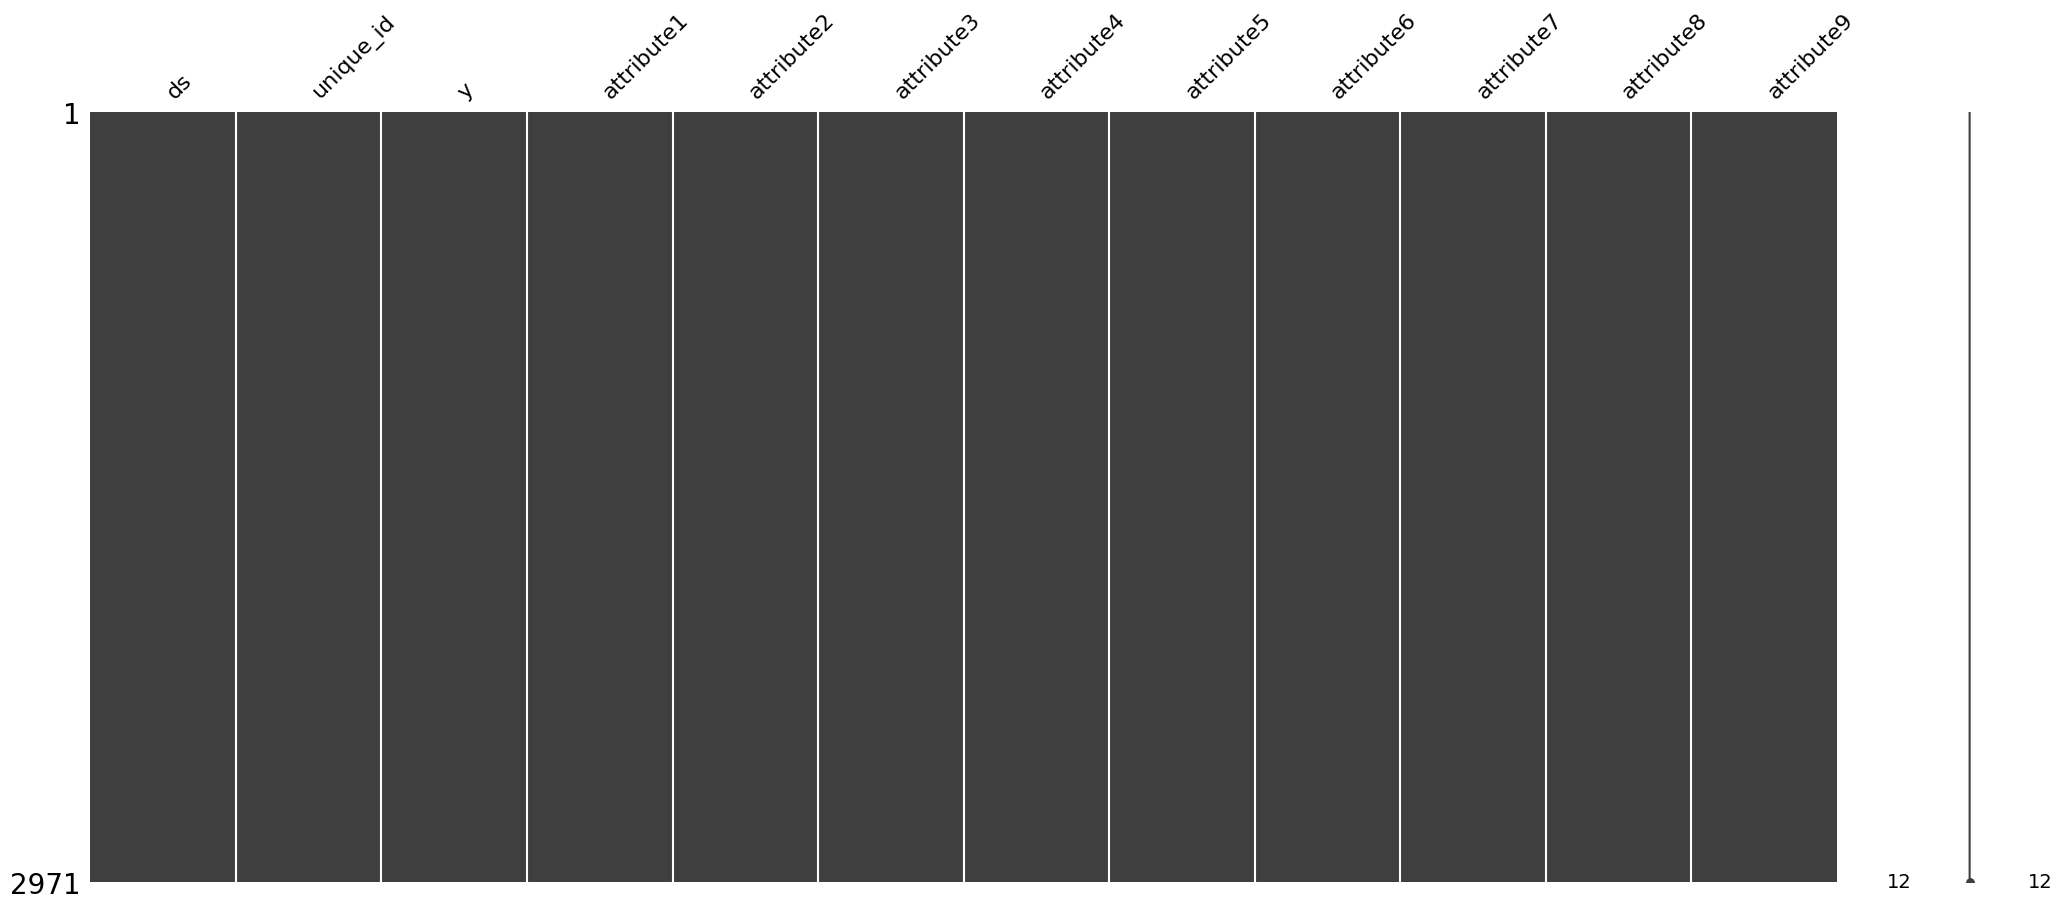

In [19]:
msno.matrix(Y_test_df)

In [12]:
# Imputar los datos faltantes 
#df_full_devices = df_full_devices.groupby('unique_id').apply(lambda group: group.interpolate(method='linear'))
#df_full_devices = df_full_devices.groupby('unique_id').apply(lambda group: group.fillna(method='bfill'))

In [13]:
# Seleccionar las columnas a imputar
features = ['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5',
            'attribute6', 'attribute7', 'attribute8', 'attribute9']

# Imputación para cada serie temporal (unique_id)
imputed_dfs = []
for uid in Y_test_df['unique_id'].unique():
    subset = Y_test_df[Y_test_df['unique_id'] == uid].copy()
    imputer = IterativeImputer(random_state=42)
    subset[features] = imputer.fit_transform(subset[features])
    imputed_dfs.append(subset)

# Combinar los dataframes imputados de nuevo
Y_test_df = pd.concat(imputed_dfs)

<Axes: >

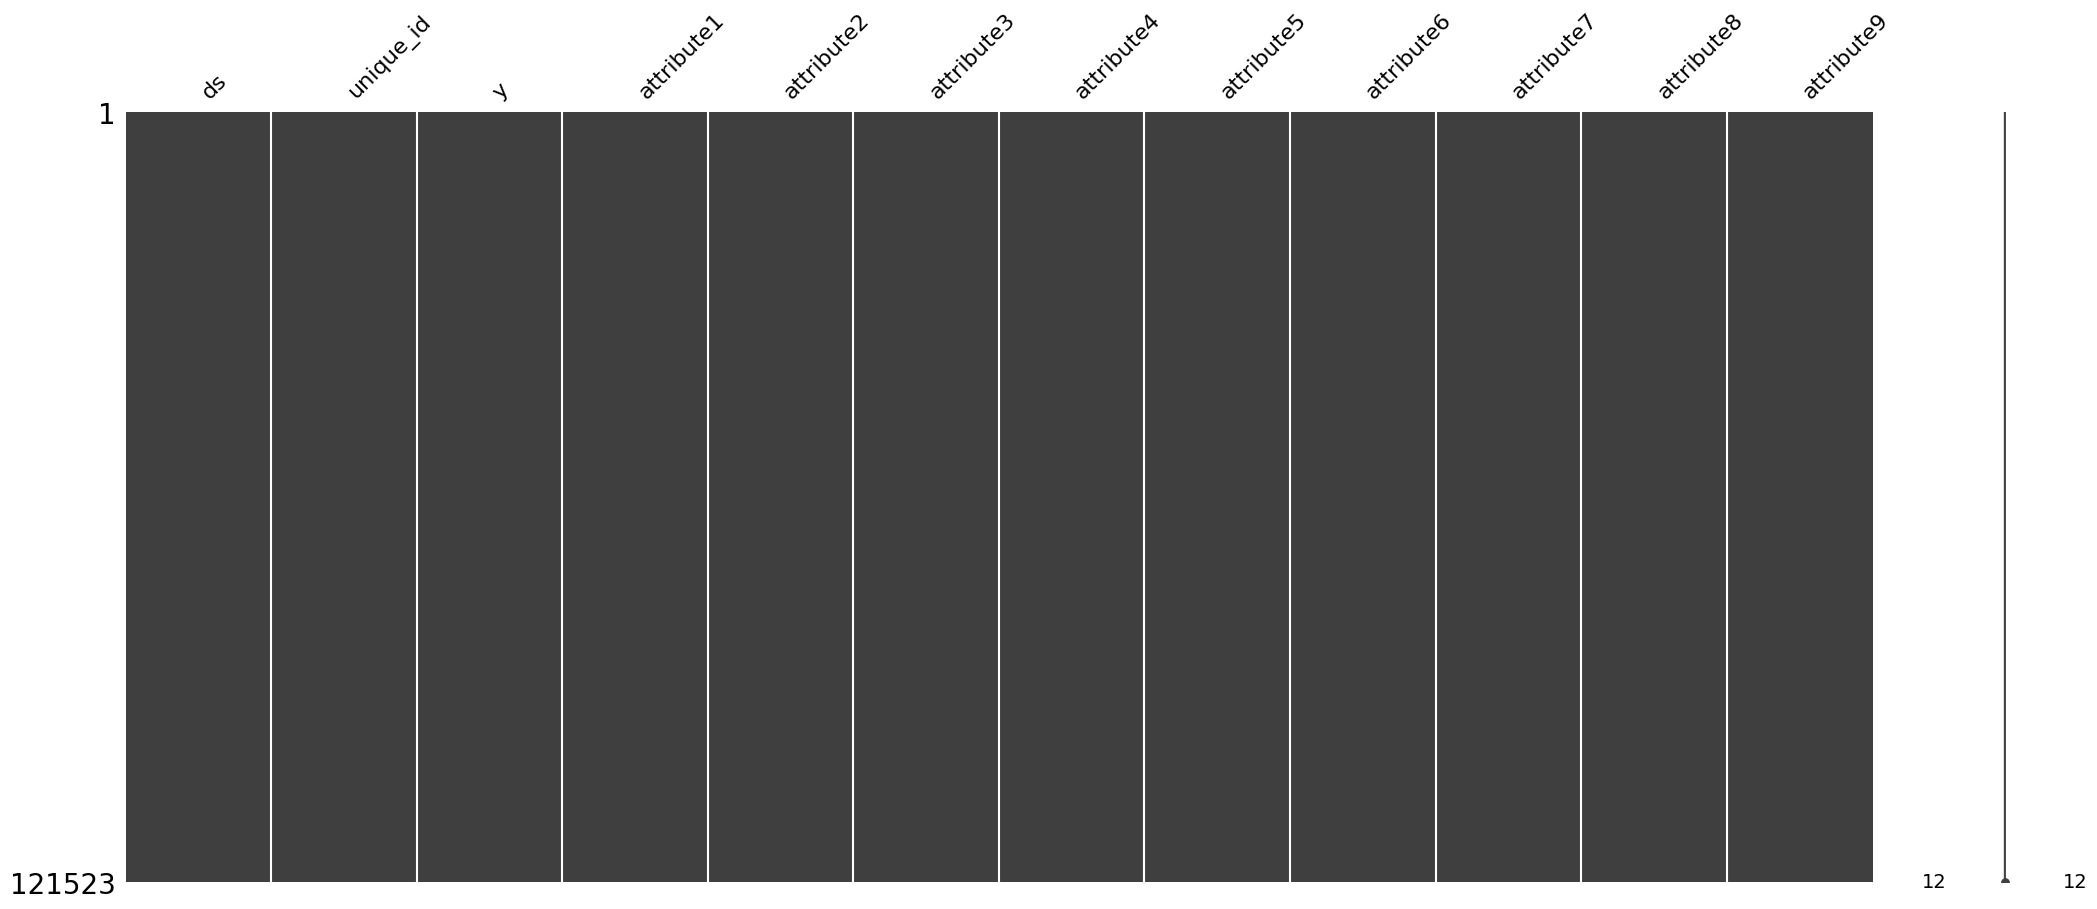

In [11]:
msno.matrix(Y_train_df)

<Axes: >

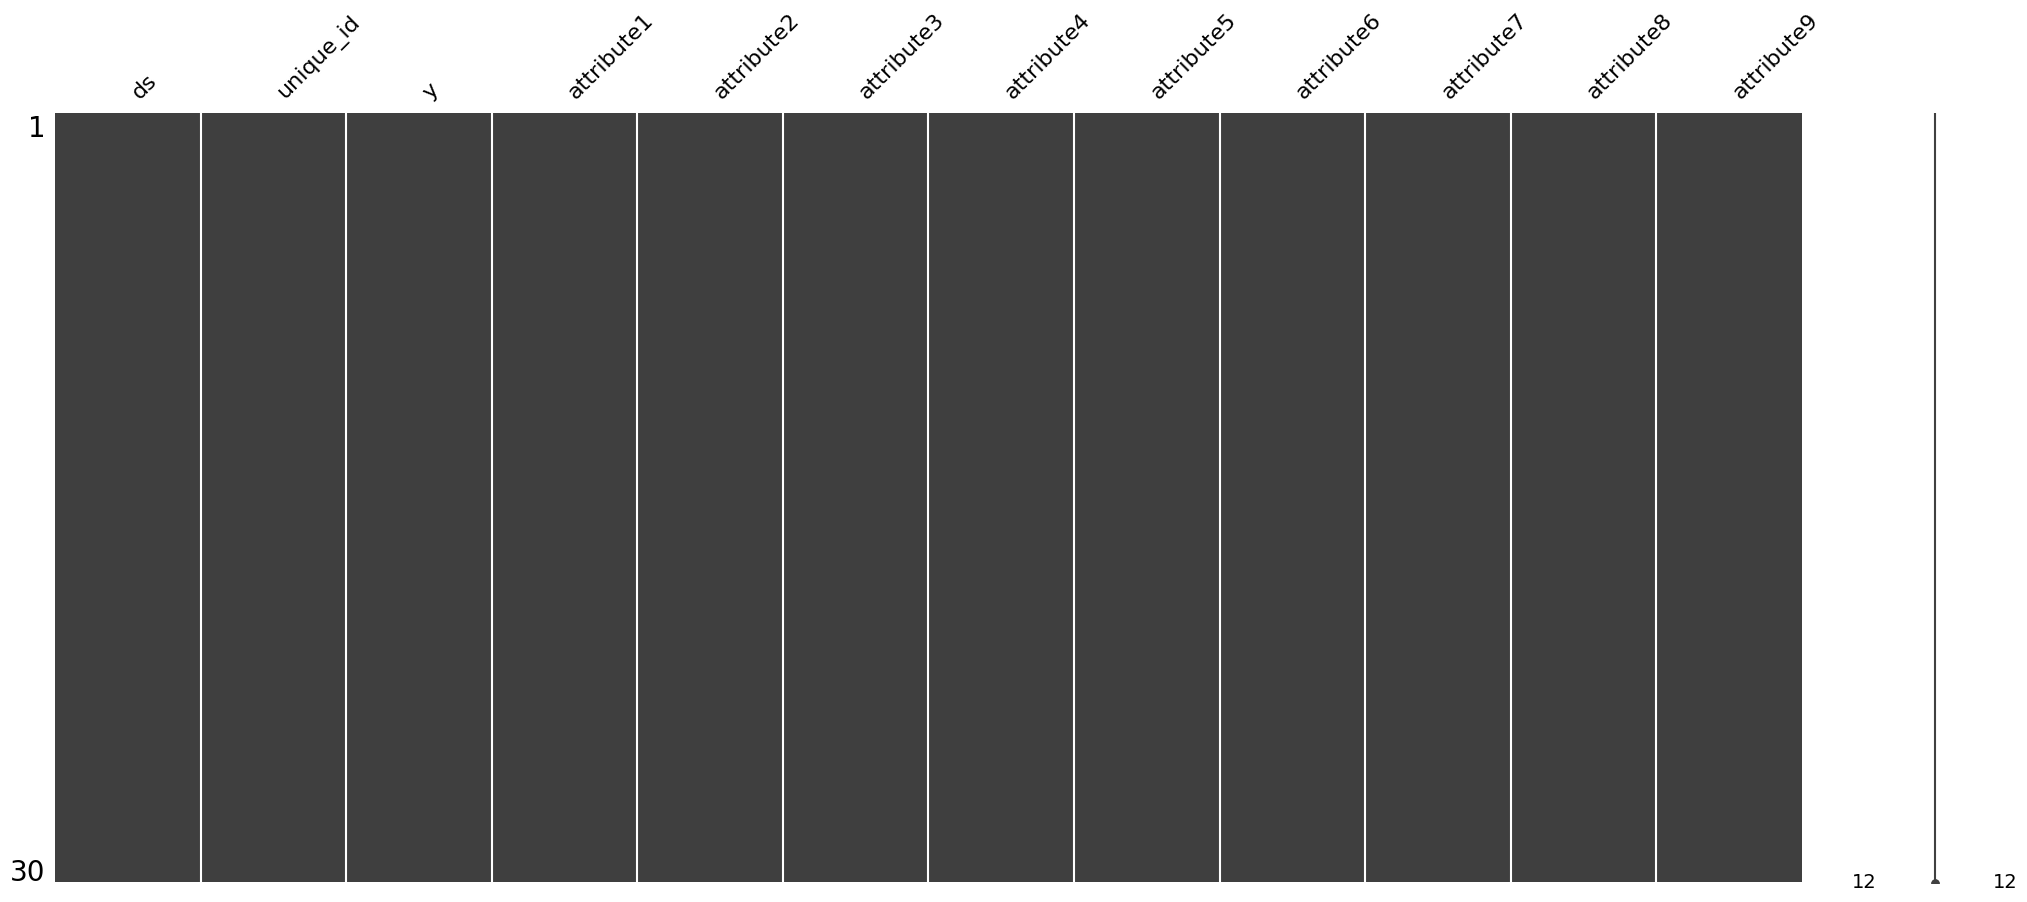

In [26]:
msno.matrix(Y_test_df.tail(30))

In [15]:
missing_combinations = fcst.get_missing_future(futr_df=Y_test_df)
if missing_combinations.empty:
    print("No hay combinaciones faltantes.")
else:
    print("Combinaciones faltantes aún presentes:", missing_combinations)

Combinaciones faltantes aún presentes:      unique_id         ds
0     S1F01085 2015-01-07
1     S1F013BB 2015-05-12
2     S1F0166B 2015-01-07
3     S1F01E6Y 2015-02-18
4     S1F01JE0 2015-01-07
...        ...        ...
1018  Z1F1RJFA 2015-05-05
1019  Z1F1VQFY 2015-07-01
1020  Z1F26YZB 2015-03-26
1021  Z1F282ZV 2015-03-26
1022  Z1F2PBHX 2015-04-07

[1023 rows x 2 columns]


In [25]:
# Realizar la predicción
forecasts = fcst.predict(futr_df=Y_test_df.tail(30))

ValueError: There are missing combinations of ids and times in `futr_df`.
You can run the `make_future_dataframe()` method to get the expected combinations or the `get_missing_future(futr_df)` method to get the missing combinations.

In [16]:
df_full_devices = df_full_devices.sort_index()  # Asegurar que los datos estén ordenados por fecha
df_full_devices

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
124489,2015-11-02,Z1F0MA1S,0,18310224,0,0,0,10,353705,8,8,0
124490,2015-11-02,Z1F0Q8RT,0,172556680,96,107,4,11,332792,0,0,13
124491,2015-11-02,Z1F0QK05,0,19029120,4832,0,0,11,350410,0,0,0
124492,2015-11-02,Z1F0QL3N,0,226953408,0,0,0,12,358980,0,0,0
